In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [124]:
# data = pd.read_csv("env_random/env_random.csv")
data = pd.read_csv("general_env/general_env.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [125]:
track_durations = (data['timestamp'].diff().dt.total_seconds() / 60).values[1:]
neg_dur = np.argwhere(track_durations < 0)
pairs = np.hstack((neg_dur-2, neg_dur+3))

for fr, to in pairs:
    print(data.iloc[fr: to])

In [126]:
data.head(20)

,timestamp,user_idx,item_idx,relevance_cont,relevance_int,terminated,true_top
0,2019-03-09 14:10:39,61,50,0.525883,4,False,[ 0 86 56 65 71 73 33 76 29 60]
1,2019-03-09 14:14:09,61,65,0.671174,4,False,[ 0 17 74 73 27 26 71 70 86 76]
2,2019-03-09 14:16:09,61,40,0.594132,4,False,[60 18 43 27 73 48 21 17 93 95]
3,2019-03-09 14:18:09,61,4,0.590600,4,False,[ 0 48 74 73 71 14 43 12 65 96]
4,2019-03-09 14:22:07,61,57,0.422119,4,False,[99 79 4 12 15 23 24 27 43 44]
5,2019-03-09 14:24:59,61,2,0.413398,3,False,[ 0 14 74 73 27 71 20 43 18 17]
6,2019-03-09 14:28:03,61,27,0.629644,3,False,[30 70 75 86 42 15 71 48 60 50]
7,2019-03-09 14:32:05,61,83,0.444625,3,False,[99 17 65 71 76 60 21 93 6 31]
8,2019-03-09 14:35:25,61,46,0.355468,3,False,[99 17 34 43 73 24 71 39 40 52]
9,2019-03-09 14:39:02,61,58,0.414233,4,False,[ 0 15 40 74 24 87 17 76 14 12]


In [127]:
def get_episodes(data):
    ends = data[data['terminated'] == True].index.values
    starts = np.zeros_like(ends)
    starts[1:] = ends[:-1] + 1
    episodes = pd.DataFrame(starts, columns=['start'])
    episodes['end'] = ends
    episodes['start_time'] = data.iloc[starts]['timestamp'].values
    episodes['end_time'] = data.iloc[ends]['timestamp'].values
    episodes['duration_min'] = (episodes['end_time'] - episodes['start_time']).dt.total_seconds() / 60
    return episodes

get_episodes(data)

,start,end,start_time,end_time,duration_min
0,0,25,2019-03-09 14:10:39,2019-03-09 15:28:25,77.766667
1,26,80,2019-03-10 00:20:44,2019-03-10 03:24:04,183.333333
2,81,122,2019-03-10 10:21:24,2019-03-10 12:41:17,139.883333
3,123,180,2019-03-10 13:55:32,2019-03-10 16:54:34,179.033333
4,181,235,2019-03-10 18:38:26,2019-03-10 21:28:57,170.516667
...,...,...,...,...,...
196,8009,8037,2019-05-10 15:17:39,2019-05-10 16:49:36,91.950000
197,8038,8074,2019-05-10 20:30:43,2019-05-10 22:22:00,111.283333
198,8075,8116,2019-05-10 22:44:30,2019-05-11 00:53:29,128.983333
199,8117,8164,2019-05-11 04:24:01,2019-05-11 06:52:31,148.500000


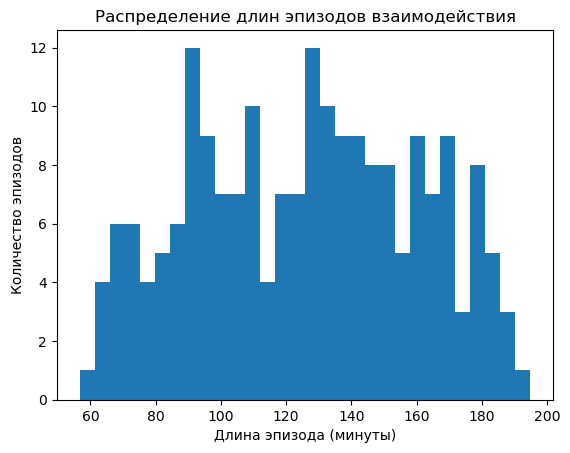

In [128]:

def calculate_interaction_lengths(data):
    # Группировка данных по пользователям и определение длины каждого эпизода взаимодействия
    data['timestamp'] = pd.to_datetime(data['timestamp']) 
    data.sort_values(['user_idx', 'timestamp'], inplace=True)  
    data['terminated_shift'] = data.groupby('user_idx')['terminated'].shift(-1)
    data['interaction_length'] = data.loc[data['terminated_shift'] == 1, 'timestamp'].diff()
    return data

def plot_interaction_lengths(data, ax=None):
    # Построение графика распределения длин эпизодов взаимодействия
    episodes = get_episodes(data)
    # data['interaction_length'] = data['interaction_length'].dt.total_seconds()
    # plt.hist(data['interaction_length'].dropna(), bins=30)
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['duration_min'], bins=30)
    ax.set_title('Распределение длин эпизодов взаимодействия')
    ax.set_xlabel('Длина эпизода (минуты)')
    ax.set_ylabel('Количество эпизодов')


# inrs = calculate_interaction_lengths(data)
plot_interaction_lengths(data)

In [129]:
def calculate_interactions_per_episode(data):
    # Добавление столбца для обозначения начала нового эпизода
    data['new_episode'] = data['terminated_shift'].shift(1).fillna(0)
     # Преобразование типа данных столбца 'new_episode' в int
    data['new_episode'] = data['new_episode'].astype(int)

    # Создание столбца с номерами эпизодов для каждого пользователя
    data['episode_idx'] = data.groupby('user_idx')['new_episode'].cumsum()

    # Подсчет количества взаимодействий за каждый эпизод
    interactions_per_episode = data.groupby(['user_idx', 'episode_idx']).size().reset_index(name='interactions')

    return interactions_per_episode


def plot_interactions_per_episode(data, ax=None):
    # Построение гистограммы распределения количества взаимодействий за эпизод
    episodes = get_episodes(data)
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['end'] - episodes['start'] + 1, bins=30)
    ax.set_title('Распределение количества взаимодействий за эпизод')
    ax.set_xlabel('Количество взаимодействий за эпизод')
    ax.set_ylabel('Количество эпизодов')

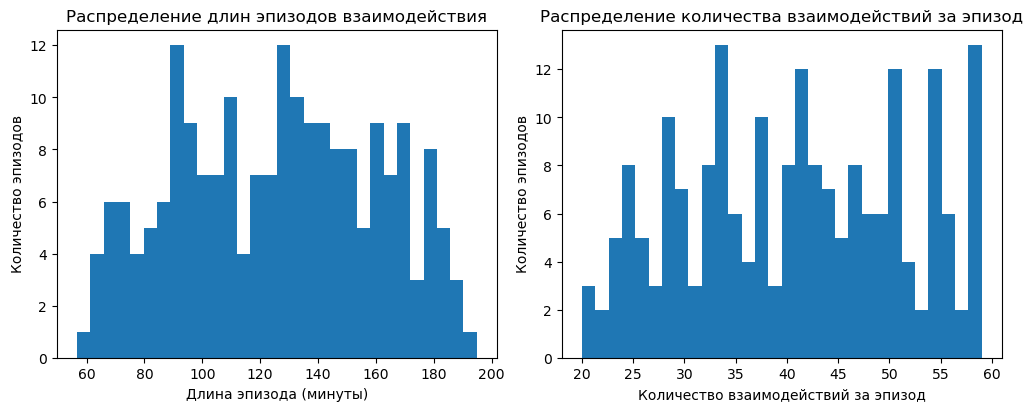

In [130]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

plot_interaction_lengths(data, axs[0])
plot_interactions_per_episode(data, axs[1])

In [131]:

# intrs = calculate_interaction_lengths(data)
# interactions_per_episode = calculate_interactions_per_episode(intrs)
# plot_interaction_lengths(intrs)
# plot_interactions_per_episode(interactions_per_episode)  # Добавлен вызов новой функции

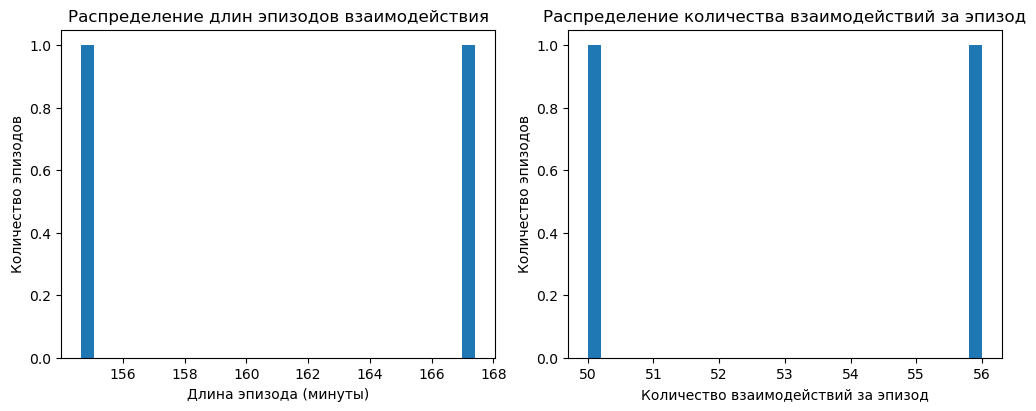

In [132]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

user_0 = data[data['user_idx'] == 6].copy()
user_0.reset_index(inplace=True)

plot_interaction_lengths(user_0, axs[0])
plot_interactions_per_episode(user_0, axs[1])

In [133]:
# user = data[data['user_idx'] == 0]

# intrs = calculate_interaction_lengths(user)
# interactions_per_episode = calculate_interactions_per_episode(intrs)
# #plot_interaction_lengths(intrs)
# plot_interactions_per_episode(interactions_per_episode)  # Добавлен вызов новой функции

In [134]:
def plot_relevance_distribution(data, discr=True, user_id=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_idx'] == user_id]
    
    if ax is None:
        ax = plt.subplot(1,1,1)
    
    col = 'relevance_int' if discr else 'relevance_cont'
        
    # Построение гистограммы распределения relevance_int
    ax.hist(data[col].dropna(), bins=30)
    ax.set_title(f'Распределение {col} для пользователя {user_id}')
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')


def plot_item_distribution(data, user_id=None, rel=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_idx'] == user_id]
    if rel is not None:
        data = data[data['relevance_int'] > rel]

    if ax is None:
        ax = plt.subplot(1,1,1)
        
    # Построение гистограммы распределения item_idx
    ax.hist(data['item_idx'].dropna(), bins=30)
    ax.set_title('Распределение item_idx для пользователя {}'.format(user_id))
    ax.set_xlabel('item_idx')
    ax.set_ylabel('Количество')

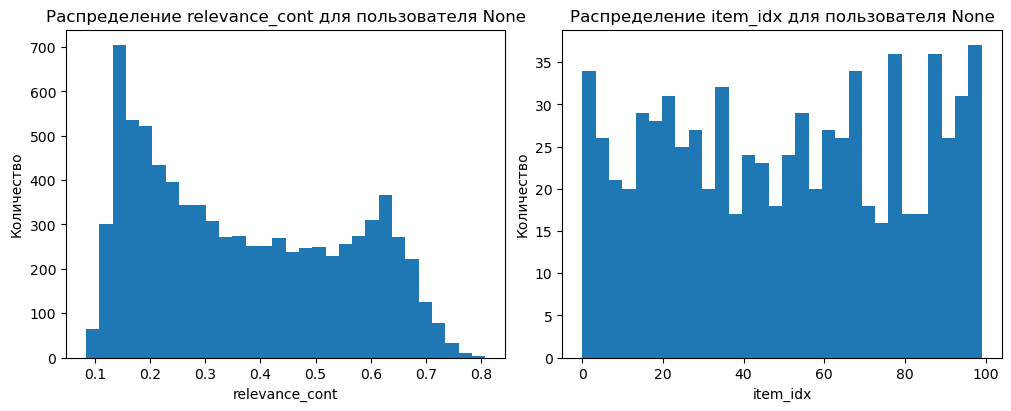

In [135]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

user_id = None
plot_relevance_distribution(data, discr=True, user_id=user_id, ax=axs[0])  # Добавлен вызов новой функции
plot_item_distribution(data, user_id=user_id, rel=4, ax=axs[1])  # Добавлен вызов новой функции

In [167]:
user = data[data['user_idx'] == 0]

In [162]:
user

,timestamp,user_idx,item_idx,relevance_cont,relevance_int,terminated,true_top,terminated_shift,interaction_length,new_episode,episode_idx
5961,2022-09-04 01:50:48,0,61,0.555307,5,False,[11 23 66 65 35 64 32 75 31 52],False,NaN,0,0
5962,2022-09-04 07:02:48,0,82,0.615722,3,False,[99 74 58 50 43 42 32 30 29 26],False,NaN,0,0
5963,2022-09-04 13:23:48,0,27,0.591523,3,False,[99 55 11 73 12 17 61 22 58 57],False,NaN,0,0
5964,2022-09-04 22:47:48,0,74,0.579658,3,False,[99 43 67 66 63 57 56 50 48 44],False,NaN,0,0
5965,2022-09-05 06:27:48,0,9,0.906516,4,False,[49 98 78 29 30 33 42 46 50 81],False,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6808,2023-02-28 20:03:48,0,4,0.921866,5,False,[49 78 27 28 29 31 71 69 34 67],False,NaN,0,2
6809,2023-03-01 00:14:48,0,87,0.529886,4,False,[49 79 77 22 51 24 73 25 26 30],False,NaN,0,2
6810,2023-03-01 07:00:48,0,81,0.940981,4,False,[49 44 69 67 65 64 63 60 58 48],False,NaN,0,2
6811,2023-03-01 10:34:48,0,81,0.940980,5,False,[99 42 56 29 76 30 74 32 43 81],True,3699780.0,0,2
